# Import Library

In [1]:
# !pip install statsmodels --upgrade
import warnings
import datetime
import plotly.express as px
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
warnings.filterwarnings('ignore')

# Load the Dataset

In [2]:
dataset = pd.read_csv("Pre-Registration Monthly Summary for Moudud.csv")
dataset.head(15)

obj_id  value2
0  2016-03   90434
1  2016-04   47651
2  2016-05    5940
3  2016-06    2278
4  2016-07      18

In [3]:
# Rename the columns name
dataset.rename(columns={"obj_id": "Date", "value2": "Total_Sales"}, inplace = True)

In [4]:
# Information of the dataset such as number of samples, colmns, data type, Non-Null value and how much memory size use.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         85 non-null     object
 1   Total_Sales  85 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


In [5]:
# Convert the date column to a datetime object and set it as the index
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)
dataset.head()

Total_Sales
Date                   
2016-03-01        90434
2016-04-01        47651
2016-05-01         5940
2016-06-01         2278
2016-07-01           18

In [6]:
dataset.shape

(85, 1)

In [7]:
# Check duplicate index
dataset.index.duplicated().sum()

0

In [8]:
dataset.describe()

Total_Sales
count      85.000000
mean    11274.752941
std     18637.906624
min        18.000000
25%      2807.000000
50%      6089.000000
75%     12860.000000
max    141160.000000

In [9]:
dataset.tail()

Total_Sales
Date                   
2023-05-01         3423
2023-06-01         1408
2023-07-01         2281
2023-08-01         5954
2023-09-01         3654

# Functions

In [10]:
def adfuller_test_function(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data has no unit root and is stationary")
    else:
        print("Data indicating it's non-stationary ")

In [11]:
def plot_test_pred_function(model_name, prediction_value):
    #plt.figure(figsize=(12,6))
    prediction_value.plot(linewidth=3,label = f"Prediction of {model_name}", c = 'r')
    test_data['Total_Sales'].plot(linewidth=3, label = "Sales of Test Data")
    plt.title(f'Prediction vs Test Data of {model_name} Model', color = 'm', size = 15, pad = 10)
    plt.ylabel("Sales")
    plt.xlabel("Date")
    plt.legend()

In [12]:
def root_mean_square_error_function(model_name, prediction_value):
    print("Mean of Test Data: ", round(test_data["Total_Sales"].mean(), 2))
    root_mean_square_error = np.sqrt(mean_squared_error(test_data["Total_Sales"], prediction_value))
    return round(root_mean_square_error,2)
    #print(f"Mean Suare Error of {model_name} Model : ", round(root_mean_square_error,2))

In [13]:
def dataset_for_future_pred_plot_function(dataset, length_of_month_future_pred):
    future_date=[dataset.index[-1]+ DateOffset(months=x+1)for x in range(0,length_of_month_future_pred)]
    future_date_df=pd.DataFrame(index=future_date[0:],columns=dataset.columns)
    future_df=pd.concat([dataset,future_date_df])
    return future_df

In [14]:
def plot_pred_future_sales_with_previoue_sales_function(model_name, forcasting_column):
    colors = ['g', 'r']
    future_df[['Total_Sales', forcasting_column]].plot(color = colors, linewidth=3, figsize=(12,6)) 
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title(f"Prediction of Future Data for {model_name}")
    plt.grid()

In [15]:
def predicted_data_function(num_of_months):
    predictions = []
    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, -n_input, n_features))
    for i in range(num_of_months):
        current_pred = model.predict(current_batch)[0]
        predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)
            
    return predictions

In [16]:
def calculate_month_difference(input_date, predefined_date):
    # Calculate the month difference between two dates
    delta = relativedelta(input_date, predefined_date)
    month_difference = delta.years * 12 + delta.months
    return month_difference


# Visualize the Data

In [17]:
fig = px.line(dataset, x=dataset.index, y=dataset.columns[0:1],
              title = "Monthly Sales of a Retail Store").update_layout(xaxis_title="Date",
                                                                                         yaxis_title="Sales")
fig.show()

# Data Preprocessing

Check Missing Value of the dataset

In [18]:
dataset.isnull().sum()

Total_Sales    0
dtype: int64

In [19]:
dataset.head()

Total_Sales
Date                   
2016-03-01        90434
2016-04-01        47651
2016-05-01         5940
2016-06-01         2278
2016-07-01           18

Rolling/Moving Average for testing Stationary

In [20]:
dataset['rolling_avg'] = dataset.Total_Sales.rolling(window = 10, min_periods = 1).mean()

fig = px.line(dataset, x=dataset.index, y=dataset.columns[0:2],
              title = "Sales of a Retail Store for Simple Moving Average").update_layout(xaxis_title="Date",
                                                                                         yaxis_title="Sales")
fig.show()

Dickey Fuller Test for testing Stationary

In [21]:
adfuller_test_function(dataset['Total_Sales'])

ADF Test Statistic : -1.5878594047208205
p-value : 0.4896892272147582
#Lags Used : 9
Number of Observations Used : 75
Data indicating it's non-stationary 


In [22]:
# Calculate the log 
dataset['log'] = np.log(dataset['Total_Sales'])
dataset

Total_Sales   rolling_avg        log
Date                                            
2016-03-01        90434  90434.000000  11.412376
2016-04-01        47651  69042.500000  10.771659
2016-05-01         5940  48008.333333   8.689464
2016-06-01         2278  36575.750000   7.731053
2016-07-01           18  29264.200000   2.890372
...                 ...           ...        ...
2023-05-01         3423   9807.000000   8.138273
2023-06-01         1408   7885.100000   7.249926
2023-07-01         2281   6662.100000   7.732369
2023-08-01         5954   6102.200000   8.691819
2023-09-01         3654   5482.400000   8.203578

[85 rows x 3 columns]

In [23]:
adfuller_test_function(dataset['log'])

ADF Test Statistic : -4.27933303828192
p-value : 0.0004822774954479808
#Lags Used : 0
Number of Observations Used : 84
Data has no unit root and is stationary


<Axes: xlabel='Date'>

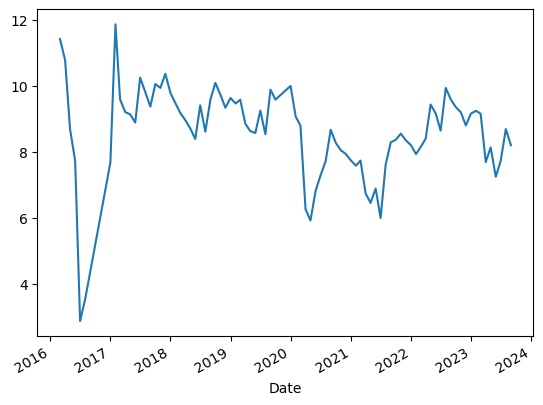

In [24]:
dataset['log'].dropna().plot()

<Axes: xlabel='Date'>

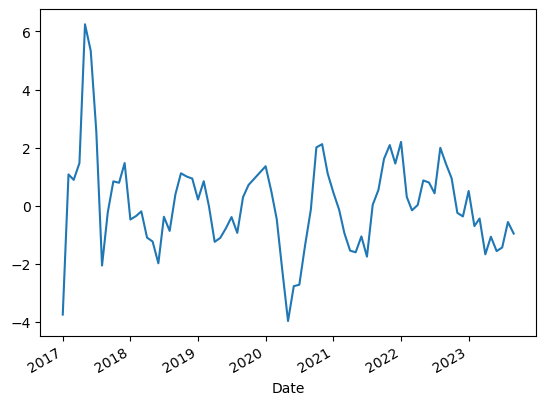

In [25]:
dataset['log_diff']  = dataset['log'] - dataset['log'].shift(6)
dataset['log_diff'].dropna().plot()

In [26]:
adfuller_test_function(dataset['log_diff'].dropna())

ADF Test Statistic : -3.6158966216890094
p-value : 0.005464290687240872
#Lags Used : 10
Number of Observations Used : 68
Data has no unit root and is stationary


Differencing for getting Stationary

In [27]:
# dataset['Sales First Difference']=dataset['Total_Sales']-dataset['Total_Sales'].shift(12)

# dataset['Seasonal First Difference']=dataset['Total_Sales']-dataset['Total_Sales'].shift(5)
# dataset.head(15)

In [28]:
# adfuller_test_function(dataset['Sales First Difference'].dropna()) # Check Stationary

In [29]:
# adfuller_test_function(dataset['Sales second Difference'].dropna()) # Check Stationary

In [30]:
# adfuller_test_function(dataset['Seasonal First Difference'].dropna()) # Check Stationary

In [31]:
# dataset["log_diff"].plot(linewidth=3, figsize=(12,6))
# plt.title("Sales First Difference", pad = 10, c = 'm')
# plt.ylabel("Sales")
# plt.xlabel("Date of Months")
# plt.grid()

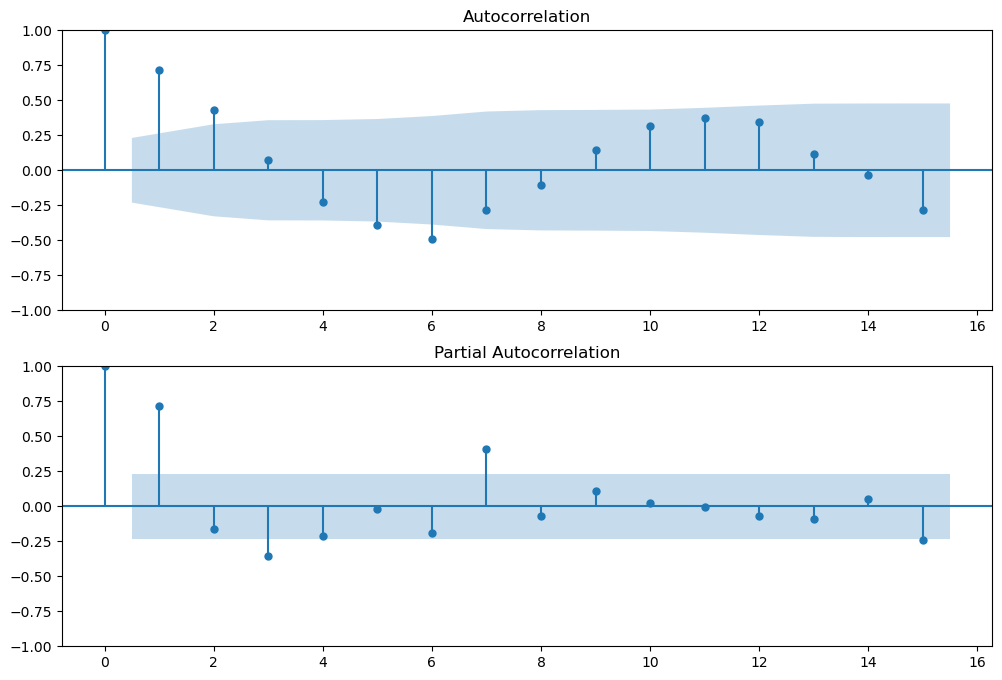

In [32]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = plot_acf(dataset['log_diff'].iloc[13:],lags=15,ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_pacf(dataset['log_diff'].iloc[13:],lags=15,ax=ax2)

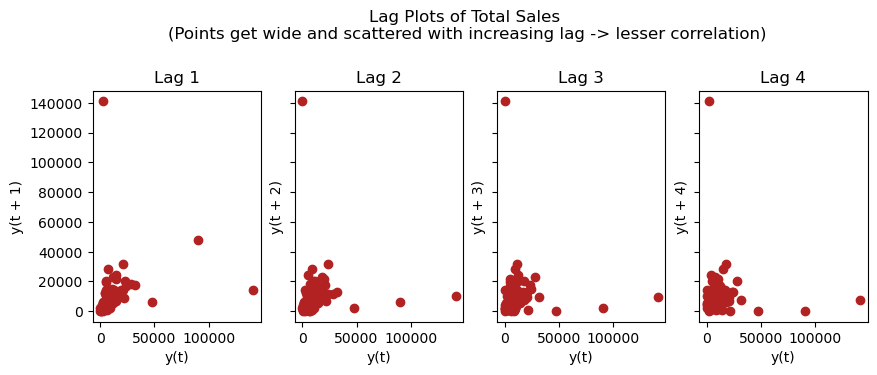

In [33]:
from pandas.plotting import lag_plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(dataset.Total_Sales, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Total Sales \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)      
plt.show();

"Grid Search" to find the optimal set of parameters.

In [34]:
# p = d = q = range(0, 4)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
# aic = []
# params = []
# param_seasonals = []
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(dataset["log_diff"],
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()
#             print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
#             params.append(param)
#             aic.append(results.aic)
#             param_seasonals.append(param_seasonal)
#         except:
#             continue
            
# print("\n\nOptimal Set of Parameters based on AIC: ")          
# min_values_index_aic = np.argmin(aic)
# print('SARIMA{}x{} - AIC:{}'.format(params[min_values_index_aic], param_seasonals[min_values_index_aic], aic[min_values_index_aic]))

In [35]:
training_size = int(len(dataset)*0.95)
train_data, test_data = dataset[0:training_size],dataset[training_size:len(dataset)] 
train_data

Total_Sales   rolling_avg        log  log_diff
Date                                                      
2016-03-01        90434  90434.000000  11.412376       NaN
2016-04-01        47651  69042.500000  10.771659       NaN
2016-05-01         5940  48008.333333   8.689464       NaN
2016-06-01         2278  36575.750000   7.731053       NaN
2016-07-01           18  29264.200000   2.890372       NaN
...                 ...           ...        ...       ...
2022-12-01         6642   9873.700000   8.801168 -0.358194
2023-01-01         9497  10479.300000   9.158731  0.516140
2023-02-01        10337  11068.100000   9.243485 -0.690871
2023-03-01         9435  10762.500000   9.152181 -0.430481
2023-04-01         2193  10031.500000   7.693026 -1.661675

[80 rows x 4 columns]

# Model Selection & Training

# ARIMA Model

In [36]:
train_data1 = train_data["log"]
train_data1

Date
2016-03-01    11.412376
2016-04-01    10.771659
2016-05-01     8.689464
2016-06-01     7.731053
2016-07-01     2.890372
                ...    
2022-12-01     8.801168
2023-01-01     9.158731
2023-02-01     9.243485
2023-03-01     9.152181
2023-04-01     7.693026
Name: log, Length: 80, dtype: float64

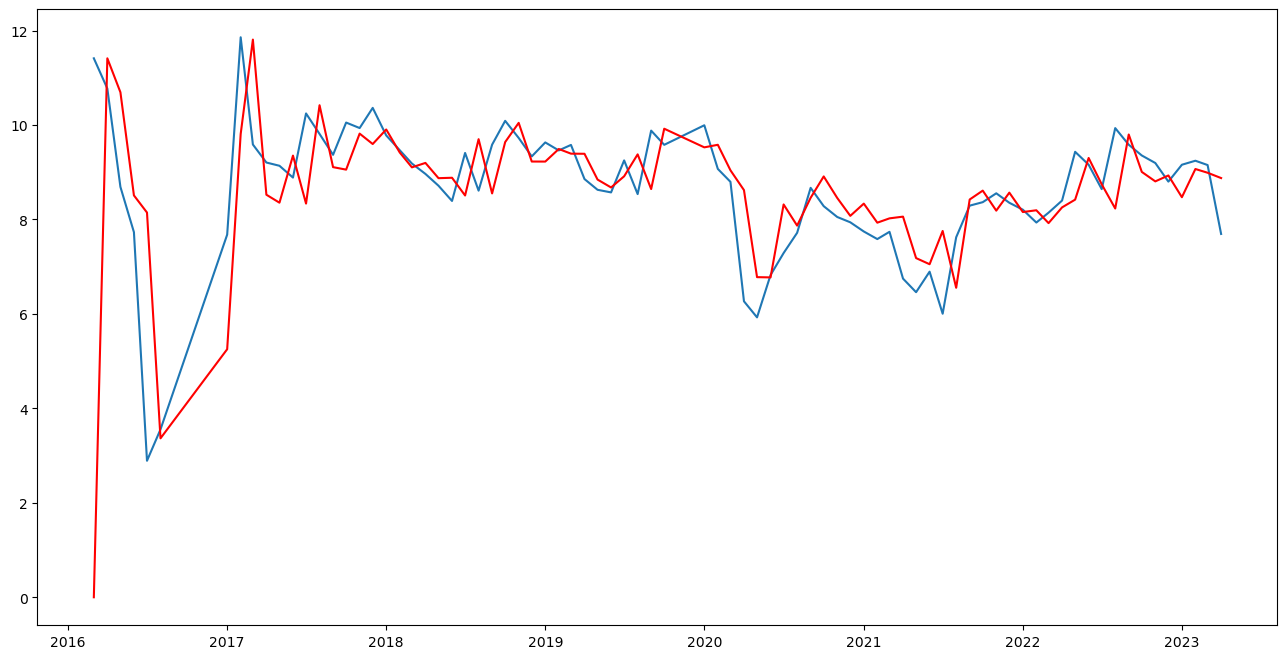

In [37]:
plt.figure(figsize=(16,8))
# model = ARIMA(train_data["log"], order=(4,1,2))  
model = ARIMA(train_data["log"], order=(3,1,3)) 
results_ARIMA = model.fit()  
plt.plot(train_data["log"])
plt.plot(results_ARIMA.fittedvalues, color='red')

In [38]:
print(results_ARIMA.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0102      0.264     -0.039      0.969      -0.528       0.508
ar.L2          0.4550      0.263      1.729      0.084      -0.061       0.971
ar.L3         -0.3107      0.291     -1.067      0.286      -0.881       0.260
ma.L1         -0.0384      0.377     -0.102      0.919      -0.778       0.701
ma.L2         -0.7900      0.300     -2.635      0.008      -1.378      -0.202
ma.L3         -0.0863      0.407     -0.212      0.832      -0.883       0.711
sigma2         0.9772      0.098     10.001      0.000       0.786       1.169


In [39]:
prediction_ARIMA = results_ARIMA.predict(start=len(train_data),end=len(train_data)+len(test_data)-1,dynamic=True)
prediction_ARIMA.index = test_data.index
prediction_ARIMA = np.exp(prediction_ARIMA)
prediction_ARIMA

Date
2023-05-01    1884.730352
2023-06-01    2511.136260
2023-07-01    4072.964898
2023-08-01    4840.646102
2023-09-01    5507.859186
Name: predicted_mean, dtype: float64

In [40]:
test_data

Total_Sales  rolling_avg       log  log_diff
Date                                                    
2023-05-01         3423       9807.0  8.138273 -1.057157
2023-06-01         1408       7885.1  7.249926 -1.551243
2023-07-01         2281       6662.1  7.732369 -1.426362
2023-08-01         5954       6102.2  8.691819 -0.551666
2023-09-01         3654       5482.4  8.203578 -0.948604

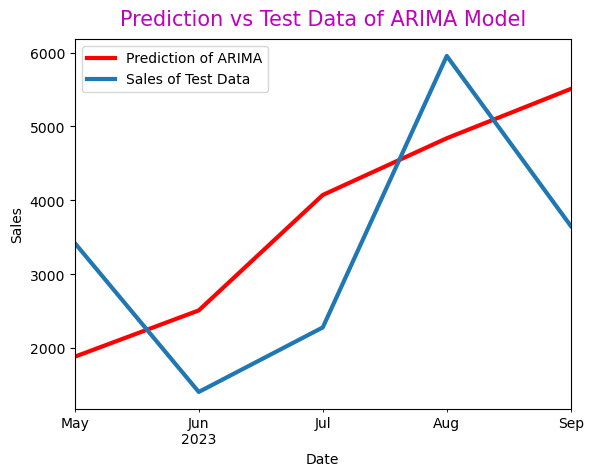

In [41]:
plot_test_pred_function("ARIMA", prediction_ARIMA)

In [42]:
rmse_arima = root_mean_square_error_function("ARIMA", prediction_ARIMA)
print("Mean Suare Error between Test data and prediction data of SARIMA Model : ", rmse_arima)

Mean of Test Data:  3344.0
Mean Suare Error between Test data and prediction data of SARIMA Model :  1514.64


# SARIMA Model

In [43]:
model=sm.tsa.statespace.SARIMAX(train_data1,order=(1,0,0),seasonal_order=(2, 1, 3, 6))
## order=(p, d, q): These are the non-seasonal components of the SARIMA model
# seasonal_order=(P, D, Q, S): These are the seasonal components of the SARIMA model
results=model.fit()

In [44]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7166      0.070     10.198      0.000       0.579       0.854
ar.S.L6       -1.1682      0.658     -1.775      0.076      -2.458       0.121
ar.S.L12      -0.6175      0.600     -1.029      0.303      -1.793       0.558
ma.S.L6        0.5622      0.655      0.858      0.391      -0.722       1.846
ma.S.L12       0.0714      0.248      0.287      0.774      -0.416       0.558
ma.S.L18      -0.5211      0.394     -1.322      0.186      -1.294       0.252
sigma2         1.0847      0.261      4.163      0.000       0.574       1.595


In [45]:
prediction_SARIMA = results.predict(start=len(train_data),end=len(train_data)+len(test_data)-1,dynamic=True)
prediction_SARIMA.index = test_data.index
prediction_SARIMA = np.exp(prediction_SARIMA)
prediction_SARIMA

Date
2023-05-01    4280.710752
2023-06-01    3397.173232
2023-07-01    2387.233799
2023-08-01    5419.937115
2023-09-01    6100.616722
Name: predicted_mean, dtype: float64

In [46]:
test_data

Total_Sales  rolling_avg       log  log_diff
Date                                                    
2023-05-01         3423       9807.0  8.138273 -1.057157
2023-06-01         1408       7885.1  7.249926 -1.551243
2023-07-01         2281       6662.1  7.732369 -1.426362
2023-08-01         5954       6102.2  8.691819 -0.551666
2023-09-01         3654       5482.4  8.203578 -0.948604

In [47]:
#print("Test data vs Predicted Data\n")
for i in range(len(test_data)):
    print(f'{test_data["Total_Sales"][i]} ------ {round(prediction_SARIMA[i], 2)}')

3423 ------ 4280.71
1408 ------ 3397.17
2281 ------ 2387.23
5954 ------ 5419.94
3654 ------ 6100.62


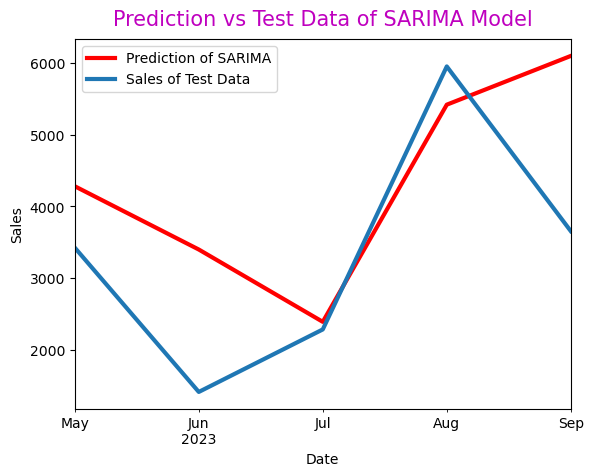

In [48]:
plot_test_pred_function("SARIMA", prediction_SARIMA)

# Model Evaluation

In [49]:
rmse_sarima = root_mean_square_error_function("SARIMA", prediction_SARIMA)
print("Mean Suare Error between Test data and prediction data of SARIMA Model : ", rmse_sarima)

Mean of Test Data:  3344.0
Mean Suare Error between Test data and prediction data of SARIMA Model :  1481.55


# Future Sales Prediction of SARIMA Model

In [50]:
predefined_date = datetime.date(2023,9,1)
year, month, day = map(int, input("Enter your expected month (YYYY-MM-DD) values but must be greater than (2023-9-1) values  : ").split("-"))
input_date = datetime.date(year, month, day)
# Calculate the month difference
expected_month = calculate_month_difference(input_date, predefined_date)


Enter your expected month (YYYY-MM-DD) values but must be greater than (2023-9-1) values  : 2024-05-01


In [51]:
forecast = results.predict(start = len(dataset)-1, end = (len(dataset)-1 + expected_month), dynamic= True)
forecast = forecast.reset_index()
print(f"Future Predicted {input_date} month Sales of a Retail Stores: ", round(np.exp(forecast["predicted_mean"][-1:]), 2))

Future Predicted 2024-05-01 month Sales of a Retail Stores:  8    5766.41
Name: predicted_mean, dtype: float64


# LSTM Model

In [52]:
train_data = train_data.drop(["rolling_avg","log", "log_diff"], axis = 1)
test_data = test_data.drop(["rolling_avg","log", "log_diff"], axis = 1)

In [53]:

# Data Scaling
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)

In [54]:
n_input = 6
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size= 1)

In [55]:
tf.keras.utils.set_random_seed(1)
#Define Model
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
# model.add(Dense(32,activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer="adam", loss = 'mse')

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [57]:
#fit model
model.fit(generator, epochs = 550)

Epoch 1/550
74/74 [==============================] - 2s 6ms/step - loss: 0.0147
Epoch 2/550
74/74 [==============================] - 0s 6ms/step - loss: 0.0145
Epoch 3/550
74/74 [==============================] - 0s 6ms/step - loss: 0.0147
Epoch 4/550
74/74 [==============================] - 1s 7ms/step - loss: 0.0142
Epoch 5/550
74/74 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 6/550
74/74 [==============================] - 1s 7ms/step - loss: 0.0141
Epoch 7/550
74/74 [==============================] - 0s 6ms/step - loss: 0.0140
Epoch 8/550
74/74 [==============================] - 1s 7ms/step - loss: 0.0143
Epoch 9/550
74/74 [==============================] - 1s 6ms/step - loss: 0.0142
Epoch 10/550
74/74 [==============================] - 1s 7ms/step - loss: 0.0140
Epoch 11/550
74/74 [==============================] - 1s 7ms/step - loss: 0.0143
Epoch 12/550
74/74 [==============================] - 1s 6ms/step - loss: 0.0146
Epoch 13/550
74/74 [=================

74/74 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 202/550
74/74 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 203/550
74/74 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 204/550
74/74 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 205/550
74/74 [==============================] - 1s 6ms/step - loss: 9.6779e-04
Epoch 206/550
74/74 [==============================] - 0s 6ms/step - loss: 9.8984e-04
Epoch 207/550
74/74 [==============================] - 0s 6ms/step - loss: 9.8106e-04
Epoch 208/550
74/74 [==============================] - 1s 7ms/step - loss: 9.3715e-04
Epoch 209/550
74/74 [==============================] - 0s 6ms/step - loss: 9.1265e-04
Epoch 210/550
74/74 [==============================] - 0s 6ms/step - loss: 9.5155e-04
Epoch 211/550
74/74 [==============================] - 0s 6ms/step - loss: 9.2249e-04
Epoch 212/550
74/74 [==============================] - 0s 6ms/step - loss: 9.3644e-0

74/74 [==============================] - 0s 5ms/step - loss: 4.3336e-04
Epoch 393/550
74/74 [==============================] - 0s 5ms/step - loss: 4.0499e-04
Epoch 394/550
74/74 [==============================] - 0s 6ms/step - loss: 3.6113e-04
Epoch 395/550
74/74 [==============================] - 1s 7ms/step - loss: 3.5641e-04
Epoch 396/550
74/74 [==============================] - 0s 6ms/step - loss: 3.7230e-04
Epoch 397/550
74/74 [==============================] - 1s 7ms/step - loss: 3.4285e-04
Epoch 398/550
74/74 [==============================] - 0s 6ms/step - loss: 4.1692e-04
Epoch 399/550
74/74 [==============================] - 1s 6ms/step - loss: 3.4645e-04
Epoch 400/550
74/74 [==============================] - 0s 6ms/step - loss: 4.1659e-04
Epoch 401/550
74/74 [==============================] - 0s 5ms/step - loss: 3.8388e-04
Epoch 402/550
74/74 [==============================] - 0s 5ms/step - loss: 3.7176e-04
Epoch 403/550
74/74 [==============================] - 0s 6ms/step -

Text(0, 0.5, 'Loss')

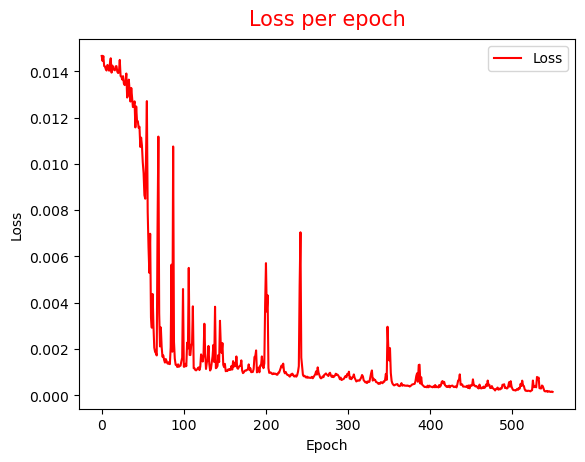

In [58]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch, c = "r", label = "Loss")
plt.title('Loss per epoch', color = 'red', size = 15, pad = 10)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [59]:
last_train_batch = scaled_train[-n_input:]

In [60]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
last_train_batch

array([[[0.06967451],
        [0.04693146],
        [0.06715931],
        [0.07311077],
        [0.06672004],
        [0.01541001]]])

In [61]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 301ms/step


array([[0.04148819]], dtype=float32)

In [62]:
test_predictions = predicted_data_function(len(test_data))

1/1 [==============================] - 0s 32ms/step


In [63]:
predictions_LSTM = scaler.inverse_transform(test_predictions)

In [64]:
test_data["predictions_LSTM"] = predictions_LSTM
print("Test data vs Predicted Data\n")
for i in range(len(test_data)):
    print(f'{test_data["Total_Sales"][i]} ------ {round(test_data["predictions_LSTM"][i], 2)}')

Test data vs Predicted Data

3423 ------ 5873.73
1408 ------ 2900.01
2281 ------ 1753.52
5954 ------ 3593.19
3654 ------ 5683.32


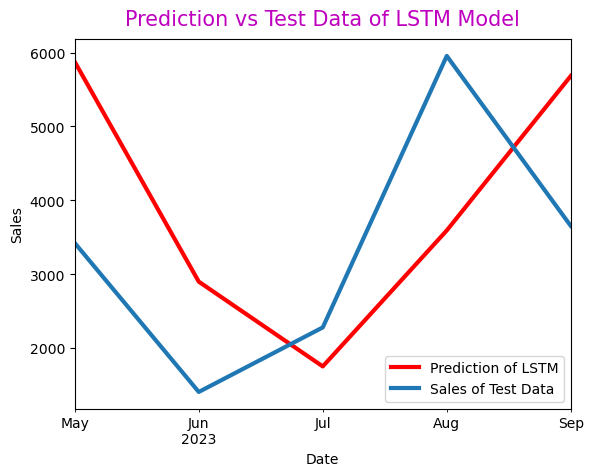

In [65]:
plot_test_pred_function("LSTM", test_data["predictions_LSTM"])


# Model Evaluation of LSTM Model

In [66]:
rmse_lstm = root_mean_square_error_function("LSTM", test_data["predictions_LSTM"])
print("Mean Suare Error between Test data and prediction data of LSTM Model : ", rmse_lstm)

Mean of Test Data:  3344.0
Mean Suare Error between Test data and prediction data of LSTM Model :  1907.98


# Future months Sales Data for LSTM

In [67]:
df = dataset.drop(["rolling_avg", "log",  "log_diff"], axis=1)

In [68]:
norm_df = scaler.fit_transform(df)
future_predictions = predicted_data_function(expected_month)

1/1 [==============================] - 0s 34ms/step


In [69]:
predictions_LSTM_future = scaler.inverse_transform(future_predictions)

In [70]:
future_df = dataset_for_future_pred_plot_function(dataset, len(predictions_LSTM_future))

In [71]:
future_df['future_sales'] = ["NaN"] * len(future_df)
j = 0 
future_df['future_sales'].iloc[len(dataset)-1] = future_df["Total_Sales"][len(dataset)-1]
for i in range((len(dataset) + len(predictions_LSTM_future))):
    if i > len(dataset)-1:
        if future_df['future_sales'].iloc[i] is not None:
            future_df['future_sales'].iloc[i] = predictions_LSTM_future[j][0]
        j += 1

In [72]:
future_df['future_sales'] = pd.to_numeric(future_df['future_sales'], errors='coerce')

Expected month Sales of a Retail Stores:  2024-05-01    9495.68
Name: future_sales, dtype: float64


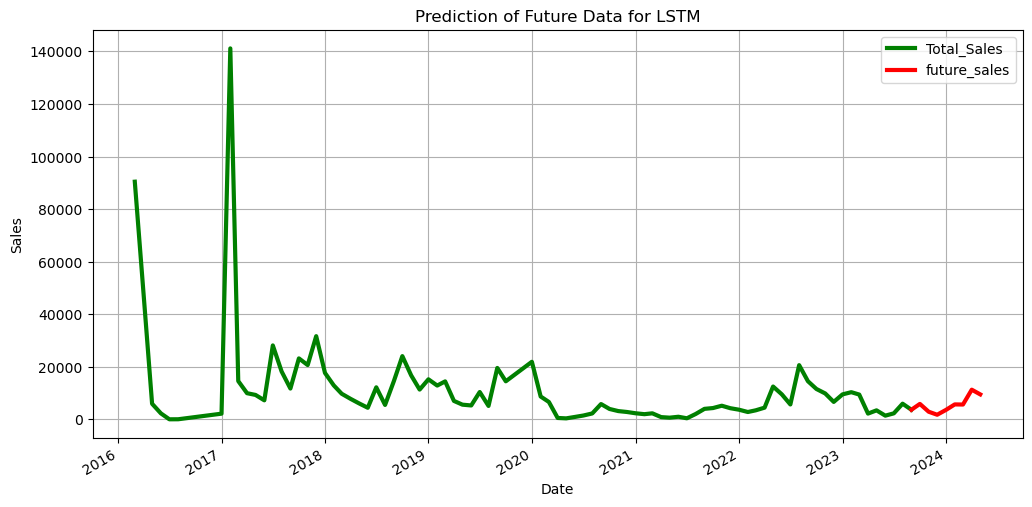

In [73]:
# print(f"Future '{expected_month}' month Sales of a Retail Stores: \n", future_df['future_sales'][-expected_month:])
print(f"Expected month Sales of a Retail Stores: ", round(future_df['future_sales'][-1:], 2))
plot_pred_future_sales_with_previoue_sales_function("LSTM", 'future_sales')

# Final Prediction

Minimum root mean square error give us the best performance of the model. In this project, LSTM model is the best preformance model as it's RMSE value is less (323.89 < 529.56) than SARIMA model.

In [74]:
print("Test data vs Predicted Data of the Best Performance LSTM Model\n")
for i in range(len(test_data)):
    print(f'{test_data["Total_Sales"][i]} ------ {round(test_data["predictions_LSTM"][i],2)}')

Test data vs Predicted Data of the Best Performance LSTM Model

3423 ------ 5873.73
1408 ------ 2900.01
2281 ------ 1753.52
5954 ------ 3593.19
3654 ------ 5683.32


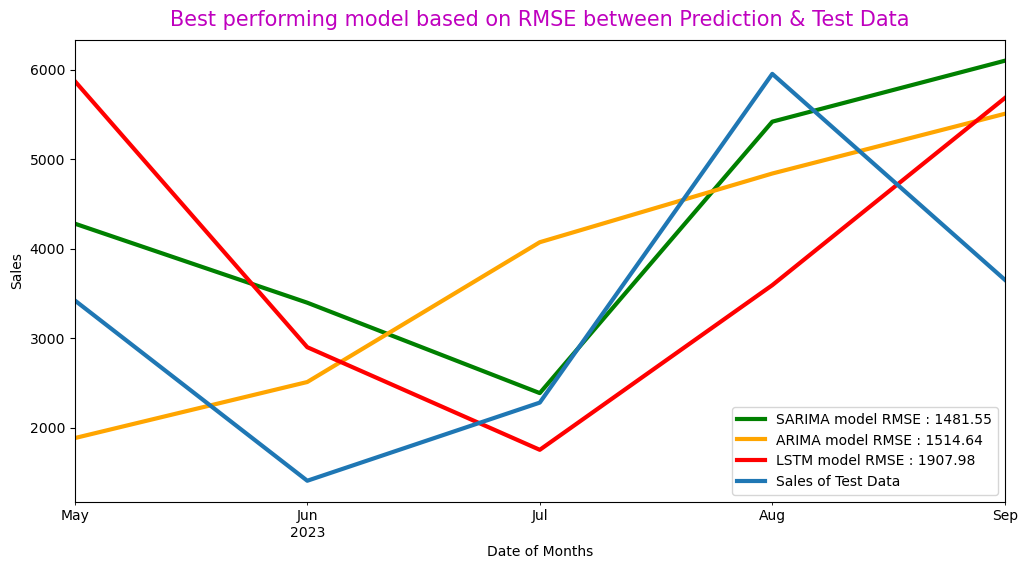

In [75]:
plt.figure(figsize=(12,6))
prediction_SARIMA.plot(linewidth=3, label = f"SARIMA model RMSE : {rmse_sarima}", c = 'g')
prediction_ARIMA.plot(linewidth=3, label = f"ARIMA model RMSE : {rmse_arima}", c = 'orange')
test_data["predictions_LSTM"].plot(linewidth=3,label = f"LSTM model RMSE : {rmse_lstm}", c = 'r')
test_data['Total_Sales'].plot(linewidth=3, label = "Sales of Test Data")
plt.title(f'Best performing model based on RMSE between Prediction & Test Data', color = 'm', size = 15, pad = 10)
plt.ylabel("Sales")
plt.xlabel("Date of Months")
plt.legend()